# Panorama Stitcthing of Images
Multiple overlapping images of the same scene, combined into a single image, can yield amazing results. This tutorial will illustrate how to accomplish panorama stitching using OpenCV, from loading the images to cleverly stitching them together.

### First things first
Import NumPy,OpenCV and matplotlib, then define a utility function to compare multiple images

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
    
# Utility to display images   
def display_side_by_side(images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

---

### 1. Load Data & Pre-processing

This stage usually involves one or more of the following:
* Resizing, often downscaling with fixed aspect ratio
* Conversion to grayscale, as some feature descriptors are not defined for color images
* Cropping to region(s) of interest

For convenience our example data is already resized smaller, and we won't bother cropping. However, they are presently in color so coversion to grayscale.

In [2]:
filenames = ['../data/stitch_images/a1.jpg','../data/stitch_images/a2.jpg']
images = [cv2.imread(each) for each in filenames]

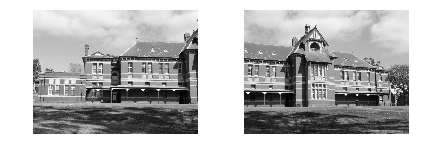

In [5]:
imgs_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
display_side_by_side(imgs_gray)

----

### 2. Feature Detection, Matching and Transform Estimation

We need to estimate a projective transformation that relates these images together. The steps will be

#### 1. Define one image as a _target_ or _destination_ image, which will remain anchored while the others are warped
#### 2. Detect features in both images
#### 3. Match features from one image against the features in the anchored image
#### 4. Find the projective transform between them.

We reuse code from our last workbook, use ORB features for finding matches and homography.

In [6]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(imgs_gray[0],None)
kp2, des2 = orb.detectAndCompute(imgs_gray[1],None)
#create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

# Match descriptors.
matches = bf.knnMatch(des1,des2,k=2)

Find good matches using lowe's ratio

In [7]:
#find good matches
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

# cv2.drawMatches expects list of lists as matches
img3 = cv2.drawMatches(imgs_gray[0],kp1,imgs_gray[1],kp2,good,None,flags=2)

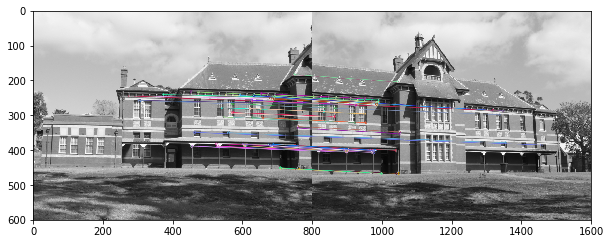

In [8]:
#Display the matches image
plt.figure(figsize=(10,10))
plt.imshow(img3)

Find Homography

In [9]:
if len(good)>4: #why 4?
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    p12, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0)

---

### 3. Warping
Next, we produce the panorama itself. We must warp, or transform, one of image so it will properly align with the other image. Then merge other image into the warped image.

In [10]:
result = cv2.warpPerspective(imgs_gray[1], p12, (imgs_gray[0].shape[1] + imgs_gray[1].shape[1], imgs_gray[0].shape[0]))
#merge the two images
result[0:imgs_gray[0].shape[0], 0:imgs_gray[0].shape[1]] = imgs_gray[0]

In [10]:
#Display the output image using matplotlib

In [9]:
print('The end!')

The end!
